# FEATURE DESCRIPTON
Relevant Information:

   The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed. 

Number of Instances: 45211 for bank-full.csv

Number of Attributes: 16 + output attribute.

Attribute information:

   Input variables:
   ##### bank client data:
   1. - age (numeric)
   2. - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3. - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4. - education (categorical: "unknown","secondary","primary","tertiary")
   5. - default: has credit in default? (binary: "yes","no")
   6. - balance: average yearly balance, in euros (numeric) 
   7. - housing: has housing loan? (binary: "yes","no")
   8. - loan: has personal loan? (binary: "yes","no")
   ##### related with the last contact of the current campaign:
   9. - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10. - day: last contact day of the month (numeric)
  11. - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12. - duration: last contact duration, in seconds (numeric)
   ##### other attributes:
  13. - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14. - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15. - previous: number of contacts performed before this campaign and for this client (numeric)
  16. - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# LOAD DATA

In [1]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('data/bank-full.csv', delimiter=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


# DATA PREPROCESSING

## DROP UNNECESSARY COLUMNS

In [5]:
df = df.drop(columns=['day', 'pdays', 'previous'])

In [6]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes(include='object')

# EXPLORATORY DATA ANALYSIS

## NUMERICAL FEATURE

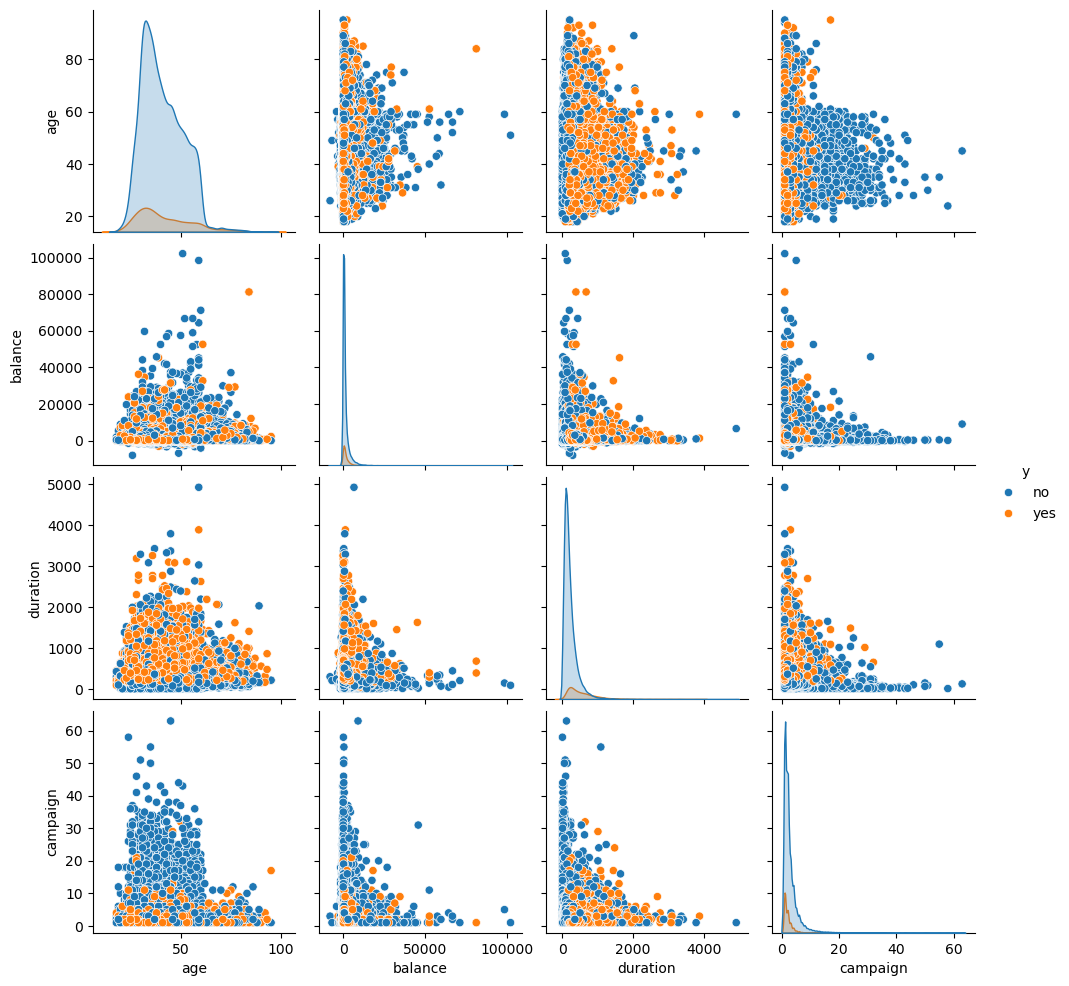

In [7]:
sns.pairplot(data=pd.concat([df_num, df_cat['y']], axis=1), hue='y')
plt.ticklabel_format(style='plain', axis='y')
plt.show()

<Axes: >

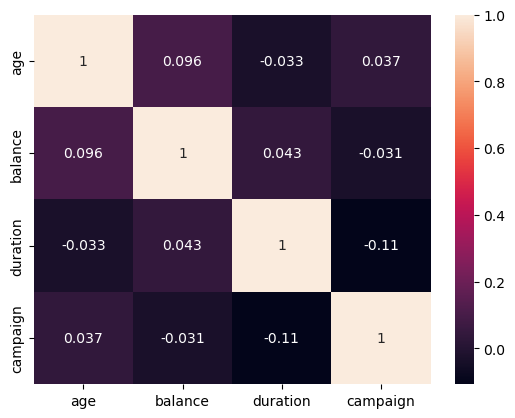

In [8]:
sns.heatmap(data=df_num.corr('spearman'), annot=True)

In [9]:
df.select_dtypes(exclude='object').describe()

,age,balance,duration,campaign
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,258.163080,2.763841
std,10.618762,3044.765829,257.527812,3.098021
min,18.000000,-8019.000000,0.000000,1.000000
25%,33.000000,72.000000,103.000000,1.000000
50%,39.000000,448.000000,180.000000,2.000000
75%,48.000000,1428.000000,319.000000,3.000000
max,95.000000,102127.000000,4918.000000,63.000000


### Based on the above plots and descriptive statistics, we can conclude:
> 1. All feature have <b>right skew distribution (non normal distribution)</b>.
> 2. The strongest correlation between features is owned by <b>duration with campaign of -0.11</b> and <b>balance with age of 0.096</b>.
> 3. <b>Average age = 40.93, Youngest age = 18, Oldest age = 95</b>
> 4. <b>Average balance = 1362.27, Smallest balance = -8019, Biggest balance = 102127</b>
> 5. <b>Average duration = 258.16, Shortest duration = 0, Longest duration = 4918</b>
> 6. <b>Average campaign = 2.76, Least campaign = 1, Most frequent campaign = 63</b>

## CATEGORICAL FEATURE

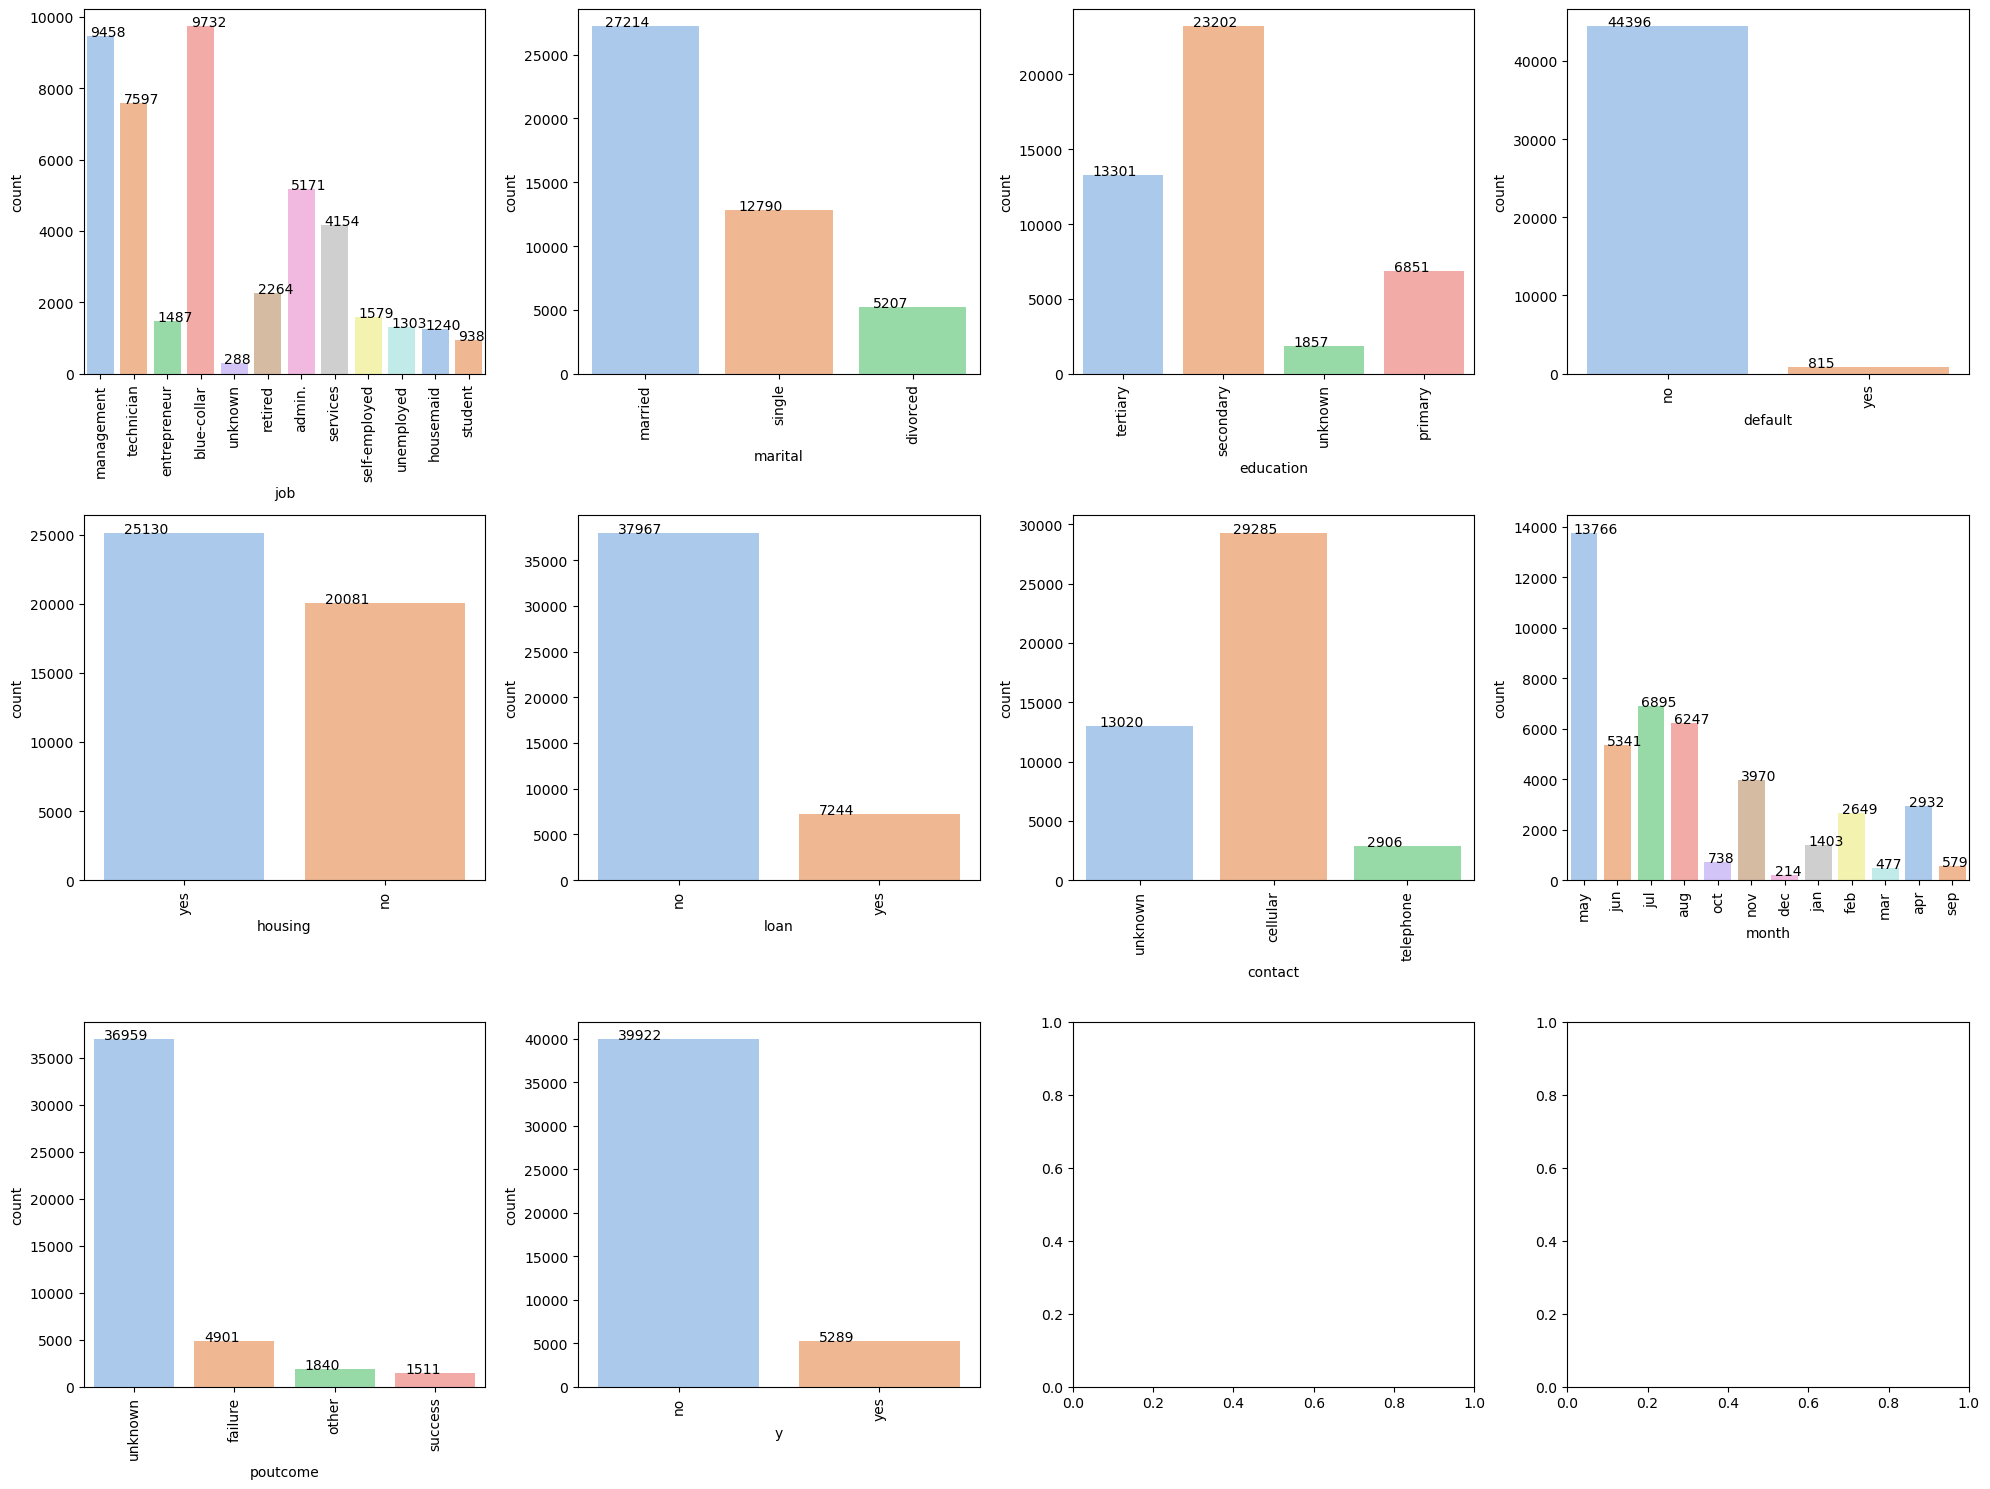

In [10]:
fig, ax = plt.subplots(3,4, figsize=(20,15))
col = 0
row = 0
for i in  df_cat:
    if col < 4:
        z = sns.countplot(data=df_cat, x=i, ax=ax[row][col], palette="pastel")
        for p in z.patches:
            z.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.02))

        plt.setp(ax[row][col].xaxis.get_majorticklabels(), rotation=90)
        col+=1
    else:
        col = 0
        row+=1
        z = sns.countplot(data=df_cat, x=i, ax=ax[row][col], palette="pastel")
        for p in z.patches:
            z.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+0.02))
        plt.setp(ax[row][col].xaxis.get_majorticklabels(), rotation=90)
        col+=1
fig.tight_layout()
plt.show()

### Based on the above plots and descriptive statistics, we can conclude:
> 1. <b>9732 customers job are blue-collar with.</b>
> 2. <b>27214 customers have married status.</b>
> 3. <b>23202 customers are secondary graduate.</b>
> 4. <b>44396 customers don't have a default.</b>
> 5. <b>Most customers already own a house as much as 25130.</b>
> 6. <b>Most customers do not have personal loans as much as 37967.</b>
> 7. <b>29285 customers are contacted through celullar.</b>
> 8. <b>Most customers were contacted in May as many as 13766.</b>
> 9. <b>Most poutcome are unknown as much as 36959.</b>
> 10. <b>A total of 39922 subscribed to term deposit and the rest don't.</b>

# FEATURE ENGINEERING

## FEATURE ENCODING

Machine learning models can only work with numerical values. For this reason, it is necessary to transform the categorical values of the relevant features into numerical ones. This process is called feature encoding.

### ONE HOT ENCODING

In [11]:
df_cat = pd.get_dummies(df_cat, prefix='job', columns=['job'])
df_cat = pd.get_dummies(df_cat, prefix='marital', columns=['marital'])
df_cat = pd.get_dummies(df_cat, prefix='default', columns=['default'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='housing', columns=['housing'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='loan', columns=['loan'], drop_first=True)
df_cat = pd.get_dummies(df_cat, prefix='poutcome', columns=['poutcome'])
df_cat = pd.get_dummies(df_cat, prefix='month', columns=['month'])
df_cat = pd.get_dummies(df_cat, prefix='contact', columns=['contact'])

In [12]:
df_cat.columns

Index(['education', 'y', 'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired', 'job_self-employed',
       'job_services', 'job_student', 'job_technician', 'job_unemployed',
       'job_unknown', 'marital_divorced', 'marital_married', 'marital_single',
       'default_yes', 'housing_yes', 'loan_yes', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'contact_cellular', 'contact_telephone',
       'contact_unknown'],
      dtype='object')

### ORDINAL ENCODING

In [13]:
education_order = ['unknown', 'primary', 'secondary', 'tertiary']
df_cat['education_enc'] = OrdinalEncoder().fit_transform(df_cat[['education']])
df_cat = df_cat.drop(columns=['education'])

### TARGET ENCODING

In [14]:
df_cat['y'] = LabelEncoder().fit_transform(df_cat[['y']])

## FEATURE SELECTION

Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested. 
Having irrelevant features in your data can decrease the accuracy of many models, especially linear algorithms like linear and logistic regression.

In [15]:
df_ft = pd.concat([df_num, df_cat], axis=1).reset_index(drop=True)

In [16]:
x = df_ft.drop(columns=['y']) #independent feature
y = df_ft['y'] #target

[0.11862216 0.12393703 0.27369663 0.07176452 0.00956955 0.00813605
 0.00455679 0.00397498 0.01081198 0.00671923 0.00562547 0.00713925
 0.00523345 0.01082359 0.00539018 0.00168341 0.00694856 0.00890194
 0.00813477 0.00310547 0.02380917 0.01282946 0.01120917 0.00668926
 0.05979932 0.01837132 0.01202143 0.00884143 0.00457884 0.00647024
 0.004551   0.00764916 0.01207024 0.01363227 0.00816928 0.00713933
 0.01184677 0.00943778 0.0099281  0.00501665 0.00962766 0.04153711]


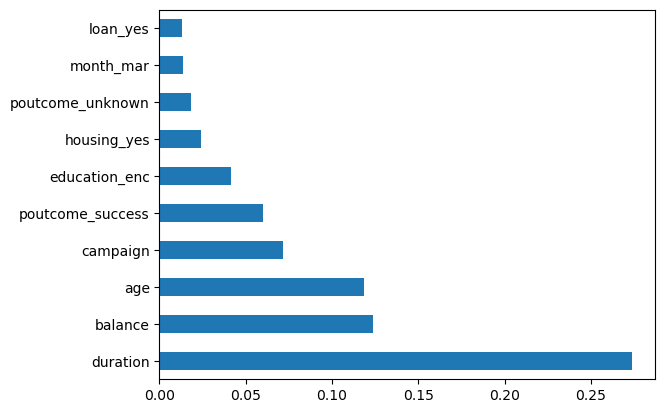

In [17]:
model = ExtraTreesClassifier()
model.fit(x,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=x.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [18]:
df_slc = pd.DataFrame()
df_slc = df_ft[feat_importances.nlargest(10).index]

In [19]:
df_slc['y'] = df_ft['y']

# MODELLING

### Decision Tree
A decision tree is one of the most powerful tools of supervised learning algorithms used for both classification and regression tasks. It builds a flowchart-like tree structure where each internal node denotes a test on an attribute, each branch represents an outcome of the test, and each leaf node (terminal node) holds a class label. It is constructed by recursively splitting the training data into subsets based on the values of the attributes until a stopping criterion is met, such as the maximum depth of the tree or the minimum number of samples required to split a node.

In [20]:
X = df_slc.drop(columns='y')
y = df_slc['y']

In [21]:
# tarin test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0) #size test 20%

In [22]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
y_pred_dt = model_dt.predict(X_test)

In [24]:
result_dt = pd.DataFrame()
result_dt['y_act'] = y_test
result_dt['y_pred'] = y_pred_dt

In [25]:
result_dt = pd.concat([X_test,result_dt], axis=1)

In [26]:
result_dt.head()

,duration,balance,age,campaign,poutcome_success,education_enc,housing_yes,poutcome_unknown,month_mar,loan_yes,y_act,y_pred
14001,91,1403,37,15,False,2.0,True,True,False,False,0,0
32046,1073,-253,36,1,False,1.0,True,True,False,False,1,0
13318,243,-406,47,5,False,0.0,False,True,False,True,0,0
42991,105,501,57,7,False,0.0,True,False,False,True,0,0
14237,332,-406,33,2,False,1.0,True,True,False,True,0,0


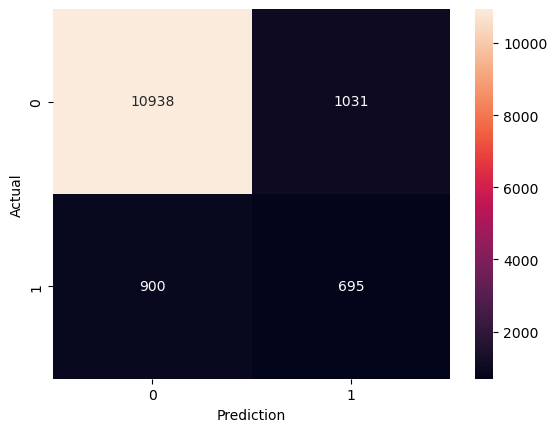

In [27]:
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [28]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.92      0.91      0.92     11969
           1       0.40      0.44      0.42      1595

    accuracy                           0.86     13564
   macro avg       0.66      0.67      0.67     13564
weighted avg       0.86      0.86      0.86     13564



### K_FOLD DECISION TREE

K-fold cross-validation is a popular technique used in machine learning for model evaluation. It's particularly useful when you have a limited amount of data and want to make the most out of it for both training and testing purposes.

In [77]:
def cv_score(model, data_x, data_y, scoring, n):
    score = cross_validate(model, data_x, data_y, cv=n, scoring=scoring, return_train_score=True)

    sns.lineplot(data=score['train_score'], label='Train', marker='o')
    sns.lineplot(data=score['test_score'], label='Test', marker='o')
    plt.show()
    return pd.DataFrame(data = [score['train_score'].mean()*100, score['test_score'].mean()*100],
                        index = ['Train', 'Test'],
                        columns =['Score (%)']
                       )
    

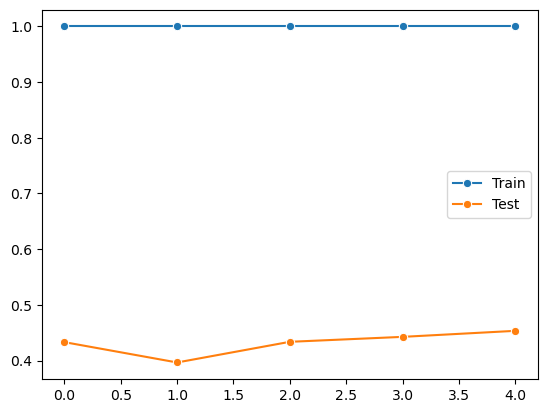

,Score (%)
Train,100.000000
Test,43.178176


In [98]:
cv_score(model_dt, X_train, y_train, 'recall', 5)

> Based on the mean score of the K-Fold train test for 5 times, it can be concluded that the model is overfit because the difference between the train and test scores is very large.

### DECISION TREE + OPTIMIZATION PARAMETERS

In [82]:
# parameter logistic regression + nilainya pada tiap parameter dalam bentuk dictionary
param = {'criterion':['gini','entropy'],
         'max_depth':np.arange(1,21).tolist()[0::2],
         'min_samples_split':np.arange(2,11).tolist()[0::2],
         'max_leaf_nodes':np.arange(3,26).tolist()[0::2]}


In [99]:
model_gs = GridSearchCV(estimator= model_dt, param_grid=param, cv=5, scoring='recall')

In [100]:
model_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'max_leaf_nodes': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21,
                                            23, 25],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             scoring='recall')

In [102]:
model_gs.best_params_

{'criterion': 'entropy',
 'max_depth': 9,
 'max_leaf_nodes': 15,
 'min_samples_split': 2}

In [103]:
model_gs_tuned = DecisionTreeClassifier(criterion='entropy', max_depth=9, max_leaf_nodes=15, min_samples_split=2) 

In [104]:
model_gs_tuned.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, max_leaf_nodes=15)

In [105]:
y_pred_gs_tuned = model_gs_tuned.predict(X_test)

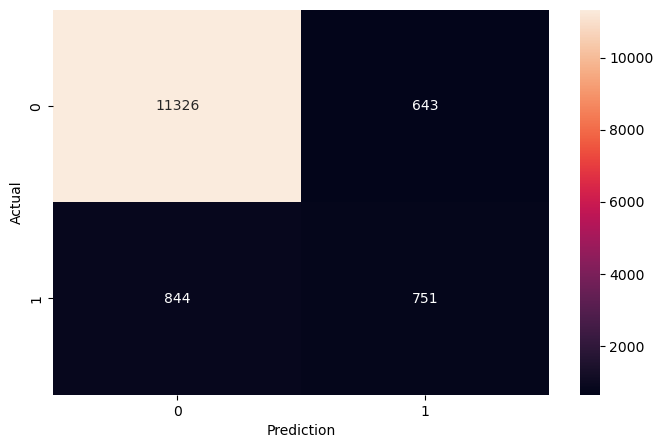

In [106]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gs_tuned), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [107]:
print(classification_report(y_test, y_pred_gs_tuned))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     11969
           1       0.54      0.47      0.50      1595

    accuracy                           0.89     13564
   macro avg       0.73      0.71      0.72     13564
weighted avg       0.88      0.89      0.89     13564



### K_FOLD DECISION TREE + OPTIMIZATION PARAMETERS

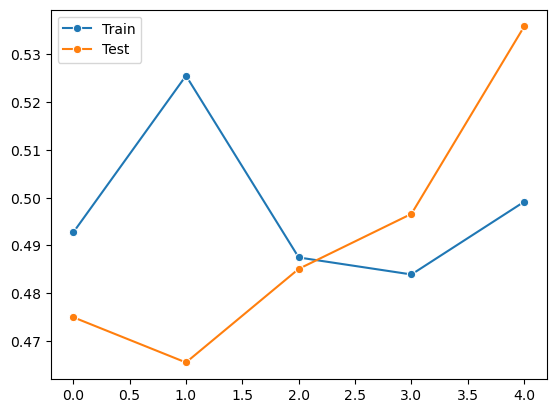

,Score (%)
Train,49.776734
Test,49.160625


In [109]:
cv_score(model_gs_tuned, X_train, y_train, 'recall', 5)

## RANDOM FOREST CLASSIFIER

Random Forest algorithm is a powerful tree learning technique in Machine Learning. It works by creating a number of Decision Trees during the training phase. Each tree is constructed using a random subset of the data set to measure a random subset of features in each partition. This randomness introduces variability among individual trees, reducing the risk of overfitting and improving overall prediction performance.

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

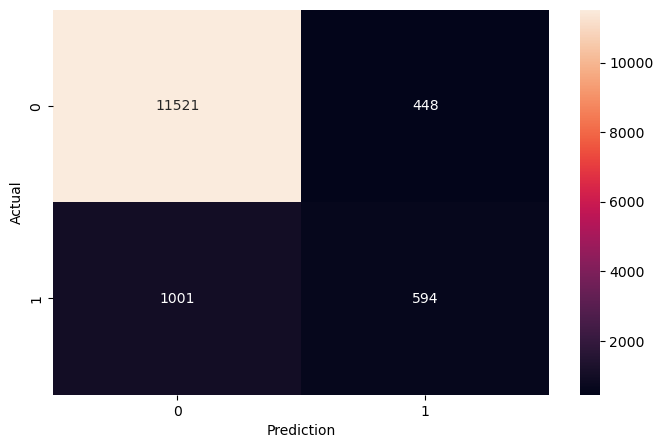

In [112]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [124]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11969
           1       0.57      0.37      0.45      1595

    accuracy                           0.89     13564
   macro avg       0.75      0.67      0.70     13564
weighted avg       0.88      0.89      0.88     13564



### K-FOLD RANDOM FOREST 

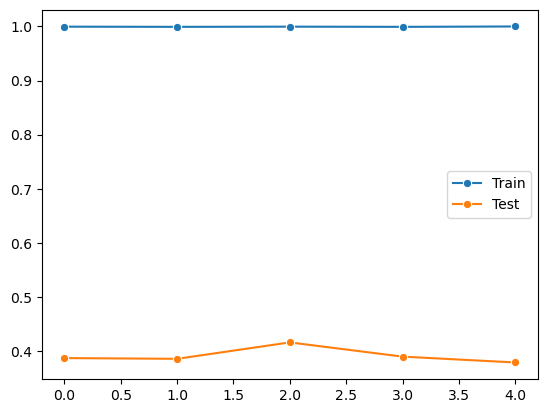

,Score (%)
Train,99.959393
Test,39.145223


In [113]:
cv_score(model_rf, X_train, y_train, 'recall', 5)

### RANDOM FOREST CLASSIFIER + OPTIMIZATION PARAMETERS

In [114]:
# parameter logistic regression + nilainya pada tiap parameter dalam bentuk dictionary
param2 =  { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 

In [115]:
model_gs_rf = GridSearchCV(estimator= model_rf, param_grid=param2, cv=5, scoring='recall')

In [116]:
model_gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='recall')

In [117]:
model_gs_rf.best_params_

{'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 50}

In [118]:
model_gs_rf_tuned = RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9, n_estimators=50) 

In [119]:
model_gs_rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=9,
                       n_estimators=50)

In [120]:
y_pred_gs_rf_tuned = model_gs_rf_tuned.predict(X_test)

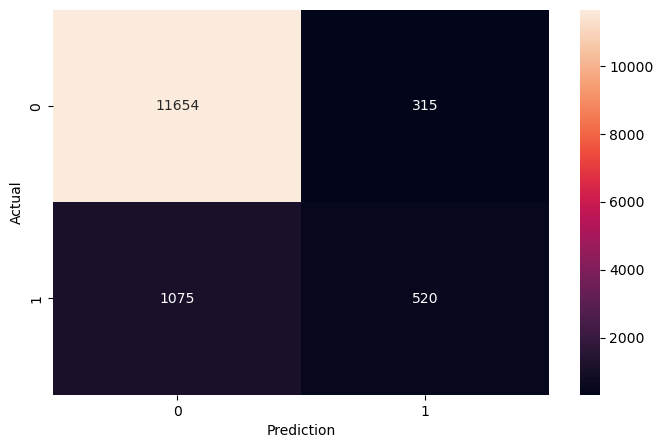

In [121]:
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_test, y_pred_gs_rf_tuned), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [122]:
print(classification_report(y_test, y_pred_gs_rf_tuned))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94     11969
           1       0.62      0.33      0.43      1595

    accuracy                           0.90     13564
   macro avg       0.77      0.65      0.69     13564
weighted avg       0.88      0.90      0.88     13564



### K-FOLD RANDOM FOREST + OPTIMIZATION PARAMETER

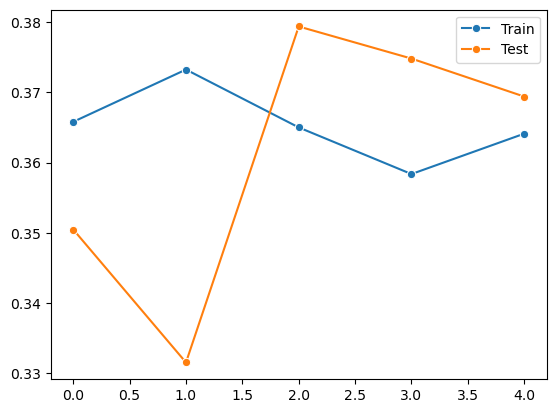

,Score (%)
Train,36.532216
Test,36.113110


In [123]:
cv_score(model_gs_rf_tuned, X_train, y_train, 'recall', 5)

## CONCLUSION MODEL

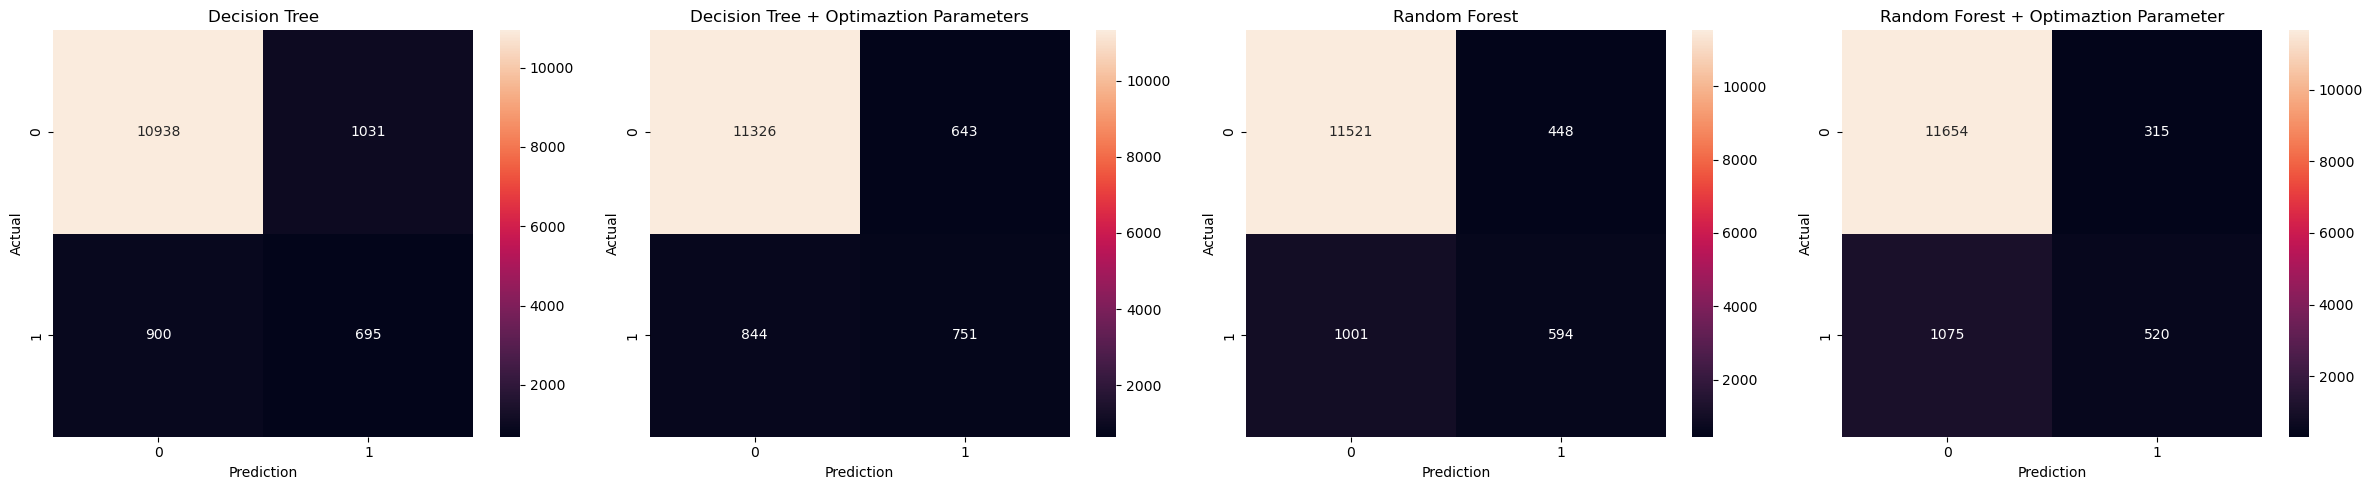

In [135]:
fig, ax = plt.subplots(1,4, figsize=(24,5))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='.0f', ax=ax[0])
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Actual')
ax[0].set_title('Decision Tree')

sns.heatmap(confusion_matrix(y_test, y_pred_gs_tuned), annot=True, fmt='.0f', ax=ax[1])
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Actual')
ax[1].set_title('Decision Tree + Optimaztion Parameters')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='.0f', ax=ax[2])
ax[2].set_xlabel('Prediction')
ax[2].set_ylabel('Actual')
ax[2].set_title('Random Forest')

sns.heatmap(confusion_matrix(y_test, y_pred_gs_rf_tuned), annot=True, fmt='.0f', ax=ax[3])
ax[3].set_xlabel('Prediction')
ax[3].set_ylabel('Actual')
ax[3].set_title('Random Forest + Optimaztion Parameter')

plt.tight_layout()
plt.show()

In [137]:
def cv_plot(model, data_x, data_y, ax, col, title):
    score = cross_validate(model, data_x, data_y, cv=5, scoring='recall', return_train_score=True)

    sns.lineplot(data=score['train_score'], label='Train', marker='o', ax=ax[col])
    sns.lineplot(data=score['test_score'], label='Test', marker='o', ax=ax[col])
    ax[col].set_title(title.upper())

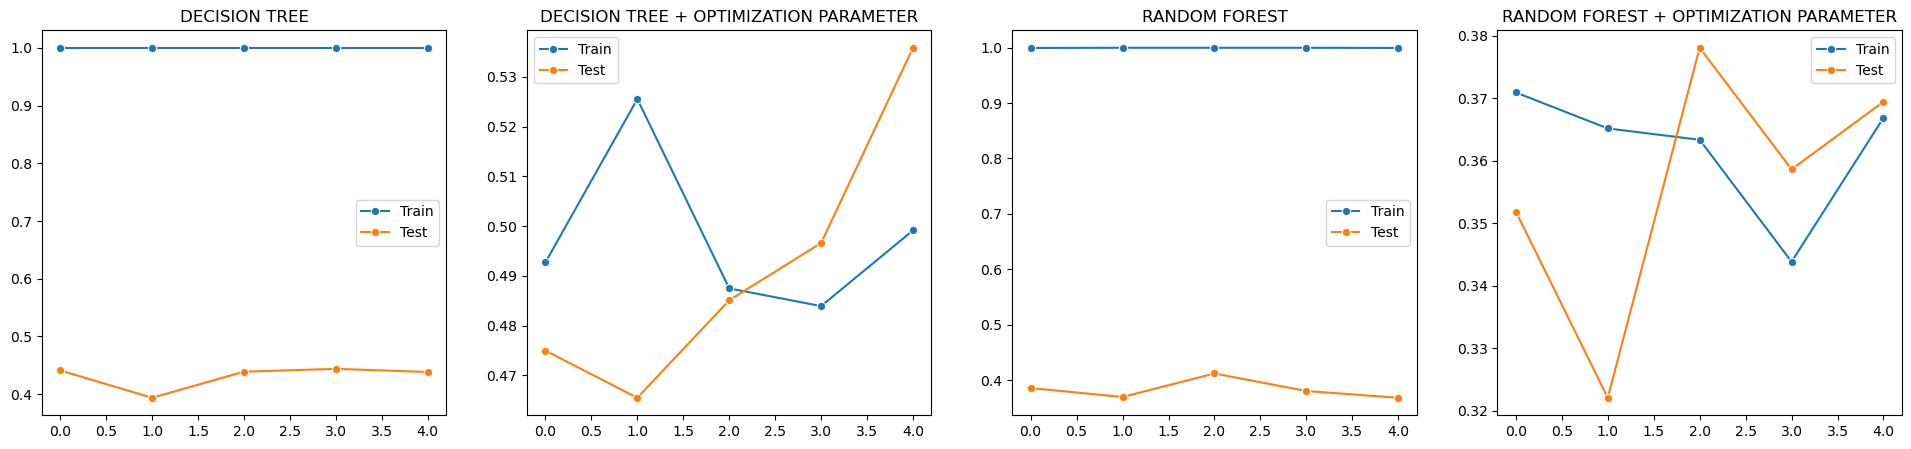

In [139]:
fig, ax = plt.subplots(1,4, figsize=(24,5))
cv_plot(model_dt, X_train, y_train, ax=ax, col = 0, title='Decision Tree')
cv_plot(model_gs_tuned, X_train, y_train, ax=ax, col = 1, title='Decision Tree + Optimization Parameter')
cv_plot(model_rf, X_train, y_train, ax=ax, col = 2, title='Random Forest')
cv_plot(model_gs_rf_tuned, X_train, y_train, ax=ax, col = 3, title='Random Forest + Optimization Parameter')

In [141]:
print('DECISION TREE')
print(classification_report(y_test, y_pred_dt))
print('\nDECISION TREE + OPTIMIZATION PARAMETER\n')
print(classification_report(y_test, y_pred_gs_tuned))
print('\nRANDOM FOREST\n')
print(classification_report(y_test, y_pred_rf))
print('\nRANDOM FOREST + OPTIMIZATION PARAMETER\n')
print(classification_report(y_test, y_pred_gs_rf_tuned))

DECISION TREE
              precision    recall  f1-score   support

           0       0.92      0.91      0.92     11969
           1       0.40      0.44      0.42      1595

    accuracy                           0.86     13564
   macro avg       0.66      0.67      0.67     13564
weighted avg       0.86      0.86      0.86     13564


DECISION TREE + OPTIMIZATION PARAMETER

              precision    recall  f1-score   support

           0       0.93      0.95      0.94     11969
           1       0.54      0.47      0.50      1595

    accuracy                           0.89     13564
   macro avg       0.73      0.71      0.72     13564
weighted avg       0.88      0.89      0.89     13564


RANDOM FOREST

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     11969
           1       0.57      0.37      0.45      1595

    accuracy                           0.89     13564
   macro avg       0.75      0.67      0.70     13564
wei

> The best model for this case is Decision tree + Parameter optimization because it has the best recall value among all models. And in this case we choose recall to be optimized because to reduce the false negative value in this case.

# CONCLUSION
> 1. All feature have <b>right skew distribution (non normal distribution)</b>.
> 2. The strongest correlation between features is owned by <b>duration with campaign of -0.11</b> and <b>balance with age of 0.096</b>.
> 3. <b>Average age = 40.93, Youngest age = 18, Oldest age = 95</b>
> 4. <b>Average balance = 1362.27, Smallest balance = -8019, Biggest balance = 102127</b>
> 5. <b>Average duration = 258.16, Shortest duration = 0, Longest duration = 4918</b>
> 6. <b>Average campaign = 2.76, Least campaign = 1, Most frequent campaign = 63</7>
> 1. <b>9732 customers job are blue-collar with.<8b>
> 2. <b>27214 customers have married status.9/b>
> 3. <b>23202 customers are secondary graduate10</b>
> 4. <b>44396 customers don't have a defaul11.</b>
> 5. <b>Most customers already own a house as much as 251120.</b>
> 6. <b>Most customers do not have personal loans as much as 371367.</b>
> 7. <b>29285 customers are contacted through celu14lar.</b>
> 8. <b>Most customers were contacted in May as many as 153766.</b>
> 9. <b>Most poutcome are unknown as much as 66959.</b>
> 10. <b>A total of 39922 subscribed to term deposit  aod the 
> 17. <b>The best model for this case is Decision tree + Optimization Parameter because it has the best recall value among all models. And in this case we choose recall to be optimized because to reduce the false negative value in this case.</b>ue in this case.